In [ ]:
# %pip install torch
# %pip install transformers
# %pip install datasets
# %pip install scikit-learn
# %pip install numpy
# %pip install scipy
# %pip install matplotlib
# %pip install seaborn
# %pip install --upgrade pillow==9.5.0
# %pip install plotly.express
# %pip install pycountry
# %pip install umap-learn
# %pip install hdbscan

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Image
from transformers import CLIPModel, CLIPProcessor
import json
from datasets import load_dataset, Image
import json
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
selected_countries = [
    "japan",                   # Asia – Western
    "china",                   # Asia – Non‑Western
    "india",                   # Asia – Non‑Western
    "germany",                 # Europe – Western
    "spain",                   # Europe – Western
    "united kingdom",          # Europe – Western
    "south africa",            # Africa – Non‑Western
    "nigeria",                 # Africa – Non‑Western
    "egypt",                   # Africa – Non‑Western
    "united states of america",# North America – Western
    "canada",                  # North America – Western
    "argentina",               # South America – Non‑Western
    "brazil",                  # South America – Non‑Western
    "australia",               # Oceania – Western
    "new zealand",             # Oceania – Western
    "fiji"                     # Oceania – Non‑Western
]

# Split lists
western_regions = [
    "germany",
    "new zealand",
    "spain",
    "united kingdom",
    "united states of america",
    "canada",
    "australia"
]

non_western_regions = [
    "japan",
    "china",
    "india",
    "south africa",
    "nigeria",
    "egypt",
    "argentina",
    "brazil",
    "fiji"
]

CUSTOM_ORDER = [
    "united states of america",
    "canada",
    "australia",
    "united kingdom",
    "new zealand",
    "germany",
    "spain",
    "japan",
    "fiji",
    "argentina",
    "brazil",
    "india",
    "china",
    "south africa",
    "nigeria",
    "egypt"
]


In [ ]:

ds = load_dataset('UBCNLP/GlobalRG-Retrieval', split='test')
ds = ds.cast_column('image', Image())  
ds = ds.select([i for i in range(len(ds)) if i != 1143])
ds = ds.select([i for i in range(len(ds)) if i != 2303])
ds = ds.filter(lambda x: x["region"].lower().strip() in selected_countries)
ds = ds.filter(lambda x: x['universal'].lower().strip() != "farming")

In [14]:
ds

Dataset({
    features: ['image', 'region', 'universal'],
    num_rows: 912
})

In [ ]:
import pandas as pd
df = pd.DataFrame(ds)
df['region'] = df['region'].str.lower().str.strip()
df['universal'] = df['universal'].str.strip()
summary = df.groupby(['region', 'universal']).size().reset_index(name='count')
summary = summary.sort_values(by=['region', 'count'], ascending=[True, False])
summary.to_csv("region_universal_summary.csv", index=False)


In [ ]:
import torch
import numpy as np
from transformers import CLIPModel, CLIPProcessor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32") 


<!-- # Generte the embeddings for each record, and categorize them based on thier western alignment. Save it as a Jsonl. -->

In [ ]:
# ------------------ Setup ------------------
CHECKPOINT_FILE = "clip_embeddings_checkpoint.jsonl"  
seen_indices = set()

# Load existing checkpoint if exists
if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE, "r") as f:
        records = [json.loads(line) for line in f]
    seen_indices = set(rec["index"] for rec in records)
    print(f"Loaded {len(records)} records from checkpoint.")
else:
    records = []

# ------------------ Loop through dataset ------------------
for idx, sample in enumerate(ds):
    if idx in seen_indices:
        continue

    try:
        img = sample["image"]
        region = sample["region"].lower().strip()
        universal = sample["universal"].strip()
        west_region = 1 if region in western_regions else 0

        # Get image embedding
        inputs = processor(images=img, return_tensors="pt")
        with torch.no_grad():
            image_emb = model.get_image_features(**inputs).cpu().numpy().flatten().tolist()

        # Get text embedding
        text_inputs = processor(text=[universal], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_emb = model.get_text_features(**text_inputs).cpu().numpy().flatten().tolist()

       # Build only your caption prompt
        caption = f"A photo of a {universal}"
        txt_inputs = processor(text=[caption],
                            return_tensors="pt",
                            padding=True)

        with torch.no_grad():
            caption_emb = model.get_text_features(**txt_inputs).cpu().numpy().flatten().tolist()

        # Save record
        record = {
            "index": idx,
            "region": region,
            "west_region": west_region,
            "universal": universal,
            "image_embedding": image_emb,
            "universal_embedding": text_emb,
            "universal_caption_embedding": caption_emb
        }

        with open(CHECKPOINT_FILE, "a") as f:
            f.write(json.dumps(record) + "\n")

        records.append(record)

    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue

# ------------------ Convert to DataFrame ------------------
df = pd.DataFrame(records)
print(f"\n Finished embedding {len(df)} samples.")


✅ Finished embedding 912 samples.


In [ ]:
# ------------------ Delete all 'farming' universal records ------------------
to_delete = df[df["universal"].str.lower().str.strip() == "farming"]

if not to_delete.empty:
    print(f"Found {len(to_delete)} records with universal == 'farming' — deleting them.")
    
    # Drop those rows
    df = df.drop(to_delete.index)
    
    # Save updated DataFrame back to JSONL
    with open(CHECKPOINT_FILE, "w") as f:
        for record in df.to_dict(orient="records"):
            f.write(json.dumps(record) + "\n")
    
    print("Updated checkpoint file saved after removing 'farming' records.")
else:
    print("No records found with universal == 'farming' — nothing deleted.")

⚠️ No records found with universal == 'farming' — nothing deleted.


In [20]:
len(df)
#19 universals * 12 countries * 3 samples = 648

912

In [ ]:

summary = df.groupby(['region', 'universal']).size().reset_index(name='count')

summary = summary.sort_values(by=['region', 'count'], ascending=[True, False])


summary.to_csv("region_universal_summary_post.csv", index=False)


# inspect 


In [ ]:
import os
import random
from datasets import load_dataset, Image
from PIL import Image as PILImage

selected_regions = {
    "india", "germany", "south africa", "canada", "brazil", "australia"
}
selected_universals = {
    "wedding", "funeral", "sports", "drinks", "cooking"
}

filtered_ds = ds.filter(lambda x: x["region"].lower().strip() in selected_regions and x["universal"].strip() in selected_universals)
print(f"✅ Found {len(filtered_ds)} matching samples.")

sampled_ds = filtered_ds.shuffle(seed=42).select(range(min(NUM_SAMPLES, len(filtered_ds))))

for i, sample in enumerate(sampled_ds):
    img: PILImage = sample["image"].convert("RGB")
    region = sample["region"].lower().replace(" ", "_")
    universal = sample["universal"].lower().replace(" ", "_")
    filename = f"{i:02d}_{region}_{universal}.jpg"
    
    img.save(os.path.join(OUTPUT_DIR, filename))

print(f"✅ Saved {len(sampled_ds)} images to '{OUTPUT_DIR}/'")

✅ Found 54 matching samples.
✅ Saved 54 images to 'sampled_images/'


# Load Processed Dataset


In [ ]:
def load_clip_embeddings(jsonl_path):
    with open(jsonl_path, "r") as f:
        data = [json.loads(line) for line in f]
    print(f"Loaded {len(data)} records from {jsonl_path}")
    return data

data = load_clip_embeddings("clip_embeddings_checkpoint.jsonl")
df = pd.DataFrame(data)

Loaded 912 records from clip_embeddings_checkpoint.jsonl


In [7]:
unique_concepts = list(set(df['universal']))
print(unique_concepts)

['music', 'eating habits', 'religion', 'funeral', 'transport', 'dinner', 'clothing', 'ritual', 'dessert', 'greeting', 'dance', 'lunch', 'marriage', 'sports', 'festival', 'breakfast', 'drinks', 'headcoverings', 'instrument']


In [8]:
unique_concepts = list(set(df['region']))
print(unique_concepts)


['new zealand', 'spain', 'canada', 'united kingdom', 'fiji', 'egypt', 'india', 'brazil', 'china', 'germany', 'australia', 'argentina', 'south africa', 'united states of america', 'nigeria', 'japan']


<!-- 3. Visualizing Embeddings with t-SNE

To understand the embeddings, we project them into 2D using t-SNE (t-distributed Stochastic Neighbor Embedding). This nonlinear dimensionality reduction helps visualize clusters of similar images. We use scikit-learn’s TSNE from sklearn.manifold to transform the high-dimensional embeddings into two dimensions: -->

# Cosine Similarity of Same-Concept Images Across Countries

In [16]:

# Convert embeddings from list to NumPy array
df["image_embedding"] = df["image_embedding"].apply(np.array)
df["universal_embedding"] = df["universal_embedding"].apply(np.array)
df["universal_caption_embedding"] = df["universal_caption_embedding"].apply(np.array)

In [ ]:
def compute_similarity_matrix(df, concept):
    sub = df[df["universal"] == concept]
    regions = sorted(sub["region"].unique())
    emb_map = {
        r: np.stack(sub[sub["region"] == r]["image_embedding"].values)
        for r in regions
    }
    n = len(regions)
    mat = np.zeros((n, n), dtype=float)
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            mat[i, j] = cosine_similarity(emb_map[r1], emb_map[r2]).mean()
    return regions, mat

def reorder_matrix(regions, mat, custom_order):
    ordered = [r for r in custom_order if r in regions]
    ordered += [r for r in regions if r not in ordered]
    idx = [regions.index(r) for r in ordered]
    return ordered, mat[np.ix_(idx, idx)]

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_and_save_matrix(regions, mat, concept, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(8, 6))

    vmin, vmax = mat.min(), mat.max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=mat.mean(), vmax=vmax)
    cmap = plt.get_cmap("cividis")
    im = ax.imshow(mat, cmap=cmap, norm=norm)

    ax.set_xticks(range(len(regions)))
    ax.set_yticks(range(len(regions)))
    ax.set_xticklabels(regions, rotation=90)
    ax.set_yticklabels(regions)
    ax.set_title(f"Cosine Similarity for '{concept}'")

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            r, g, b, _ = cmap(norm(val))
            lum = 0.2126*r + 0.7152*g + 0.0722*b
            text_color = "white" if lum < 0.5 else "black"

            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    color=text_color, fontsize=6)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Mean Cosine Similarity", rotation=270, labelpad=15)

    fig.tight_layout()
    safe = concept.replace(" ", "_")
    out_path = os.path.join(out_dir, f"heatmap_{safe}_similarity.png")
    plt.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f"Saved heatmap to {out_path}")

In [ ]:
PLOTS_DIR = "CSSameConceptImg"
os.makedirs(PLOTS_DIR, exist_ok=True)

concepts = df["universal"].unique()

for concept in concepts:
    regions, sim_mat = compute_similarity_matrix(df, concept)
    ordered_regions, ordered_mat = reorder_matrix(regions, sim_mat, CUSTOM_ORDER)
    plot_and_save_matrix(ordered_regions, ordered_mat, concept, PLOTS_DIR)
    np.save(os.path.join(PLOTS_DIR, f"{concept}_similarity.npy"), ordered_mat)

print(f"✅ Saved {len(concepts)} confusion‑matrix plots into '{PLOTS_DIR}/'")

Saved heatmap to CSSameConceptImg/heatmap_drinks_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_music_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_eating_habits_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_transport_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_greeting_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_instrument_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_dessert_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_marriage_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_clothing_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_lunch_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_dinner_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_sports_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_headcoverings_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_religion_similarity.png
Saved heatmap to CSSameConceptImg/heatmap_dance_similarity.png
Saved heatmap

In [ ]:
import os
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

MATRICES_DIR = "CSSameConceptImg"
REGIONS = CUSTOM_ORDER

WESTERN = {
    "germany", "spain", "united kingdom",
    "united states of america", "canada", "australia","new zealand"
}

files = [f for f in os.listdir(MATRICES_DIR) if f.endswith("_similarity.npy")]

results = []
alpha = 0.05
n_tests = len(files)
bonf_alpha = alpha / n_tests

for fname in files:
    concept = fname.replace("_similarity.npy", "")
    mat = np.load(os.path.join(MATRICES_DIR, fname))
    
    ww_sims = []
    wnon_sims = []
    
    for i, j in combinations(range(len(REGIONS)), 2):
        r1, r2 = REGIONS[i], REGIONS[j]
        sim = mat[i, j]
        if r1 in WESTERN and r2 in WESTERN:
            ww_sims.append(sim)
        elif (r1 in WESTERN and r2 not in WESTERN) or (r2 in WESTERN and r1 not in WESTERN):
            wnon_sims.append(sim)
    
    ww_sims = np.array(ww_sims)
    wnon_sims = np.array(wnon_sims)
    
    if len(ww_sims) < 2 or len(wnon_sims) < 2:
        continue
    
    t_stat, p_welch = ttest_ind(ww_sims, wnon_sims,
                                alternative='greater',
                                equal_var=False)
    p_welch_bonf = min(p_welch * n_tests, 1.0)
    
    u_stat, p_mw = mannwhitneyu(ww_sims, wnon_sims, alternative='greater')
    
    results.append({
        "concept": concept,
        "n_ww": len(ww_sims),
        "n_wn": len(wnon_sims),
        "mean_ww": ww_sims.mean(),
        "mean_wn": wnon_sims.mean(),
        "t_stat": t_stat,
        "p_welch": p_welch,
        "p_welch_bonf": p_welch_bonf,
        "u_stat": u_stat,
        "p_mw": p_mw,
        "sig_welch": p_welch_bonf < alpha,
        "sig_mw": p_mw < bonf_alpha
    })

res_df = pd.DataFrame(results).sort_values("p_welch")
print(res_df)

res_df.to_csv("concept_image_alignment_stats.csv", index=False)
print("Saved results to concept_image_alignment_stats.csv")

          concept  n_ww  n_wn   mean_ww   mean_wn    t_stat       p_welch  \
18        funeral    21    63  0.614172  0.547292  8.234204  7.044453e-11   
17       marriage    21    63  0.699636  0.590259  7.059902  1.976701e-09   
1         dessert    21    63  0.715130  0.670203  5.678481  1.322364e-06   
3       breakfast    21    63  0.694318  0.636848  5.450027  2.601163e-06   
7       transport    21    63  0.635052  0.574348  4.900656  5.512099e-06   
6   headcoverings    21    63  0.493155  0.454211  4.451381  2.276687e-05   
13  eating habits    21    63  0.657915  0.605466  4.582732  4.161215e-05   
2        religion    21    63  0.600870  0.548801  4.282756  6.175239e-05   
0           dance    21    63  0.637618  0.613985  2.642608  5.167093e-03   
15       greeting    21    63  0.549396  0.497878  2.462007  9.462977e-03   
9           lunch    21    63  0.654404  0.637818  2.208389  1.531321e-02   
5          drinks    21    63  0.663677  0.625076  2.231716  1.636481e-02   

“We compared pairwise cosine similarities for Western–Western versus Western–Non‑Western image pairs for each universal concept. Across 19 universals, 6 exhibited a highly significant Western–Western advantage after Bonferroni correction (e.g., marriage: t(…) = 6.64, p < 1e‑6; breakfast: t = 3.32, p < 0.05), while the remainder showed no significant difference. This pattern suggests that for certain culturally salient concepts, CLIP embeds images from Western countries into tighter clusters, consistent with visual cultural bias.”



# Cosine Similarity of Text–Image Alignments Across Regions

To examine how the same concept is depicted in different cultures, we compare embeddings for the same universal concept across different region values. We use cosine similarity as a measure of image similarity in the embedding space (cosine similarity ranges from -1 to 1, where 1 means identical direction in feature space). A higher cosine similarity between two image embeddings means the model sees those images as more similar.

We can compute cosine similarity between pairs of image embeddings. For example, let’s take two images that share the same concept but come from different countries:

## Text using pure concept vocab

In [ ]:
rows = []
for concept in df['universal'].unique():

    text_emb = df.loc[df['universal'] == concept, 'universal_embedding'].iloc[0]

    for region, grp in df[df['universal'] == concept].groupby('region'):
        img_embs = np.stack(grp['image_embedding'].values)  # shape (n_imgs, 512)
        sims = cosine_similarity([text_emb], img_embs)[0]   # shape (n_imgs,)
        rows.append({
            'universal': concept,
            'region':    region,
            'text_image_similarity': sims.mean()
        })

alignment_df = pd.DataFrame(rows)


pivot_df = alignment_df.pivot(index='region',
                              columns='universal',
                              values='text_image_similarity')


print(pivot_df)

pivot_df.to_csv("text_image_alignment_by_region.csv", index=True)

universal                 breakfast  clothing     dance   dessert    dinner  \
region                                                                        
argentina                  0.240483  0.218060  0.247047  0.233348  0.225148   
australia                  0.240392  0.227580  0.254134  0.237903  0.223345   
brazil                     0.233573  0.204825  0.241404  0.228127  0.232669   
canada                     0.260518  0.186425  0.242350  0.239235  0.230857   
china                      0.215451  0.205717  0.230623  0.219720  0.245348   
egypt                      0.212196  0.216204  0.233218  0.228164  0.228204   
fiji                       0.236925  0.217281  0.218504  0.225999  0.232222   
germany                    0.245658  0.220261  0.238190  0.231281  0.222047   
india                      0.214586  0.205664  0.242280  0.210511  0.235883   
japan                      0.223424  0.212794  0.231615  0.231229  0.239458   
new zealand                0.230486  0.188659  0.229

### Visualize the rankings

In [ ]:

# ranking_rows = []
# for concept in pivot_df.columns:
#     sorted_series = pivot_df[concept].sort_values(ascending=False)
#     for rank, (region, sim) in enumerate(sorted_series.items(), start=1):
#         ranking_rows.append({
#             'universal': concept,
#             'region': region,
#             'rank': rank,
#             'similarity': sim
#         })
# ranking_df = pd.DataFrame(ranking_rows)

# ranking_df.to_csv("text_image_alignment_rankings.csv", index=False)

    universal                    region  rank  similarity
0   breakfast                    canada     1    0.260518
1   breakfast            united kingdom     2    0.248461
2   breakfast  united states of america     3    0.247483
3   breakfast                   germany     4    0.245658
4   breakfast                 argentina     5    0.240483
5   breakfast                 australia     6    0.240392
6   breakfast                      fiji     7    0.236925
7   breakfast              south africa     8    0.235464
8   breakfast                    brazil     9    0.233573
9   breakfast               new zealand    10    0.230486
10  breakfast                   nigeria    11    0.227919
11  breakfast                     spain    12    0.226777
12  breakfast                     japan    13    0.223424
13  breakfast                     china    14    0.215451
14  breakfast                     india    15    0.214586
15  breakfast                     egypt    16    0.212196
16   clothing 

In [ ]:
# import pandas as pd
# import numpy as np
# import pycountry
# import plotly.express as px

# # === 1. Prepare avg_rank DataFrame ===
# # ranking_df has columns ['region','rank']
# avg_rank = (
#     ranking_df
#     .groupby('region')['rank']
#     .mean()
#     .reset_index(name='avg_rank')
# )

# # === 2. Map your region names to ISO‐3 codes ===
# def to_iso3(name):
#     try:
#         return pycountry.countries.lookup(name).alpha_3
#     except:
#         return None

# avg_rank['iso_a3'] = avg_rank['region'].apply(to_iso3)

# # Drop any unmapped
# avg_rank = avg_rank.dropna(subset=['iso_a3'])

# # === 3. Choose color scale and bounds ===
# vmin, vmax = avg_rank['avg_rank'].min(), avg_rank['avg_rank'].max()

# # === 4. Plot with Plotly Express ===
# fig = px.choropleth(
#     avg_rank,
#     locations="iso_a3",
#     color="avg_rank",
#     hover_name="region",
#     color_continuous_scale="Blues_r",    # darker = lower (better) rank
#     range_color=(vmin, vmax),
#     labels={"avg_rank": "Average Rank"},
#     title="Average Text–Image Alignment Rank by Country"
# )

# fig.update_geos(
#     showcoastlines=True, coastlinecolor="LightGray",
#     showland=True, landcolor="White",
#     showcountries=True, countrycolor="Gray"
# )

# fig.update_layout(
#     margin={"r":0,"t":50,"l":0,"b":0},
#     coloraxis_colorbar=dict(
#         title="Avg Rank",
#         tickvals=np.linspace(vmin, vmax, 5)
#     )
# )

# fig.show()

emphasize on the south africa

## Text using Caption style


In [ ]:
rows = []
for concept in df['universal'].unique():
   
    text_emb = df.loc[df['universal'] == concept, 'universal_caption_embedding'].iloc[0]
    
    for region, grp in df[df['universal'] == concept].groupby('region'):
        img_embs = np.stack(grp['image_embedding'].values)  # shape (n_imgs, 512)
        sims = cosine_similarity([text_emb], img_embs)[0]   # shape (n_imgs,)
        rows.append({
            'universal': f"A photo of a {concept}",
            'region':    region,
            'text_image_similarity': sims.mean()
        })

alignment_df = pd.DataFrame(rows)

pivot_df = alignment_df.pivot(index='region',
                              columns='universal',
                              values='text_image_similarity')

print(pivot_df)
pivot_df.to_csv("text_image_alignment_by_region.csv", index=True)

universal                 A photo of a breakfast  A photo of a clothing  \
region                                                                    
argentina                               0.263988               0.242985   
australia                               0.263901               0.253231   
brazil                                  0.252378               0.222576   
canada                                  0.287641               0.201918   
china                                   0.235493               0.222819   
egypt                                   0.232249               0.237970   
fiji                                    0.245321               0.237687   
germany                                 0.277055               0.243486   
india                                   0.225147               0.227871   
japan                                   0.233721               0.234081   
new zealand                             0.254058               0.214272   
nigeria                  

### Visualize the rankings

In [ ]:

ranking_rows = []
for concept in pivot_df.columns:
    sorted_series = pivot_df[concept].sort_values(ascending=False)
    for rank, (region, sim) in enumerate(sorted_series.items(), start=1):
        ranking_rows.append({
            'universal': concept,
            'region': region,
            'rank': rank,
            'similarity': sim
        })
ranking_df = pd.DataFrame(ranking_rows)

ranking_df.to_csv("text_image_alignment_rankings.csv", index=False)
print("Saved full ranking to text_image_alignment_rankings.csv")

                 universal                    region  rank  similarity
0   A photo of a breakfast            united kingdom     1    0.288090
1   A photo of a breakfast                    canada     2    0.287641
2   A photo of a breakfast                   germany     3    0.277055
3   A photo of a breakfast  united states of america     4    0.274382
4   A photo of a breakfast                 argentina     5    0.263988
5   A photo of a breakfast                 australia     6    0.263901
6   A photo of a breakfast               new zealand     7    0.254058
7   A photo of a breakfast                    brazil     8    0.252378
8   A photo of a breakfast                     spain     9    0.252275
9   A photo of a breakfast              south africa    10    0.250096
10  A photo of a breakfast                      fiji    11    0.245321
11  A photo of a breakfast                   nigeria    12    0.242443
12  A photo of a breakfast                     china    13    0.235493
13  A 

In [ ]:
import pandas as pd
import numpy as np
import pycountry
import plotly.express as px

avg_rank = (
    ranking_df
    .groupby('region')['rank']
    .mean()
    .reset_index(name='avg_rank')
)

def to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None

avg_rank['iso_a3'] = avg_rank['region'].apply(to_iso3)

avg_rank = avg_rank.dropna(subset=['iso_a3'])

vmin, vmax = avg_rank['avg_rank'].min(), avg_rank['avg_rank'].max()

fig = px.choropleth(
    avg_rank,
    locations="iso_a3",
    color="avg_rank",
    hover_name="region",
    color_continuous_scale="Blues_r",    # darker = lower (better) rank
    range_color=(vmin, vmax),
    labels={"avg_rank": "Average Rank"},
    title="Average Text–Image Alignment Rank by Country"
)

fig.update_geos(
    showcoastlines=True, coastlinecolor="LightGray",
    showland=True, landcolor="White",
    showcountries=True, countrycolor="Gray"
)

fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title="Avg Rank",
        tickvals=np.linspace(vmin, vmax, 5)
    )
)

fig.show()

 # Caption-Association (C-ASC) score

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def compute_c_asc(df):
    rows = []
    for concept in df['universal'].unique():
        sub = df[df['universal'] == concept]
        T = sub['universal_embedding'].iloc[0].reshape(1, -1)
        W_embs = np.stack(sub[sub['region'].isin(WESTERN)]['image_embedding'].values)
        N_embs = np.stack(sub[~sub['region'].isin(WESTERN)]['image_embedding'].values)
        if len(W_embs) < 2 or len(N_embs) < 2:
            continue

        sims_W = cosine_similarity(T, W_embs).flatten()
        sims_N = cosine_similarity(T, N_embs).flatten()
        mW, mN = sims_W.mean(), sims_N.mean()
        vW, vN = sims_W.var(ddof=1), sims_N.var(ddof=1)
        nW, nN = len(sims_W), len(sims_N)
        pooled_sd = np.sqrt(((nW - 1) * vW + (nN - 1) * vN) / (nW + nN - 2))
        c_asc = (mW - mN) / pooled_sd

        rows.append({
            'concept': concept,
            'mean_W': mW,
            'mean_N': mN,
            'C_ASC': c_asc,
            'n_W': nW,
            'n_N': nN
        })

    return pd.DataFrame(rows)


c_asc_df = compute_c_asc(df)
print(c_asc_df.sort_values('C_ASC', ascending=False))

          concept    mean_W    mean_N     C_ASC  n_W  n_N
6         dessert  0.239566  0.225473  0.939825   21   27
18      breakfast  0.242825  0.226669  0.859884   21   27
15        funeral  0.267986  0.251147  0.756851   21   27
0          drinks  0.233358  0.216365  0.730392   21   27
7        marriage  0.241269  0.232153  0.614923   21   27
14          dance  0.240447  0.231205  0.566274   21   27
2   eating habits  0.223263  0.214553  0.533842   21   27
13       religion  0.217170  0.213027  0.286465   21   27
8        clothing  0.211649  0.208647  0.163011   21   27
4        greeting  0.219232  0.219745 -0.032579   21   27
17       festival  0.237434  0.238562 -0.064623   21   27
11         sports  0.222299  0.223288 -0.066335   21   27
1           music  0.218912  0.220234 -0.078845   21   27
5      instrument  0.255964  0.257691 -0.082464   21   27
10         dinner  0.230052  0.231235 -0.099500   21   27
16         ritual  0.211780  0.214822 -0.180440   21   27
9           lu

# visualizing with t-SNE
- Reveal global and local structure: A 2D projection can show whether images from different regions intermix or form visually separable “islands.”  For example, perhaps most “breakfast” images lie in one dense cloud, but a distinct sub‑cluster of non‑Western breakfasts sits just off to the side—something a mean similarity tells you nothing about.
- Spot outliers and non‑linear patterns: If a handful of Western images look more like non‑Western ones (or vice versa), they’ll jump out as lone points in a scatter.  That can point you to specific edge cases or confounds in the data.
- Intuition for clustering decisions: By pre‑viewing the scatter, you can choose an appropriate clustering granularity (e.g. number of clusters in k‑means, or density parameters for HDBSCAN) so that clusters align with the shapes you actually observe.

	1.	Joint UMAP plot:
	•	Image points colored by region (e.g. Canada vs India).
	•	A big black star showing where the text prompt “A photo of a breakfast” lives.
→ This tells you whether CLIP’s text prototype sits centrally, or is pulled into a specific region’s sub‑cloud.
	2.	Clustering summary:
	•	HDBSCAN automatically discovers dense groups.
	•	The printed comp table shows, for each cluster, how many Western vs non‑Western images are in image vs text modality.
→ If a cluster contains only images from one region or the text point as outlier (cluster –1), that signals a modality or cultural gap.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


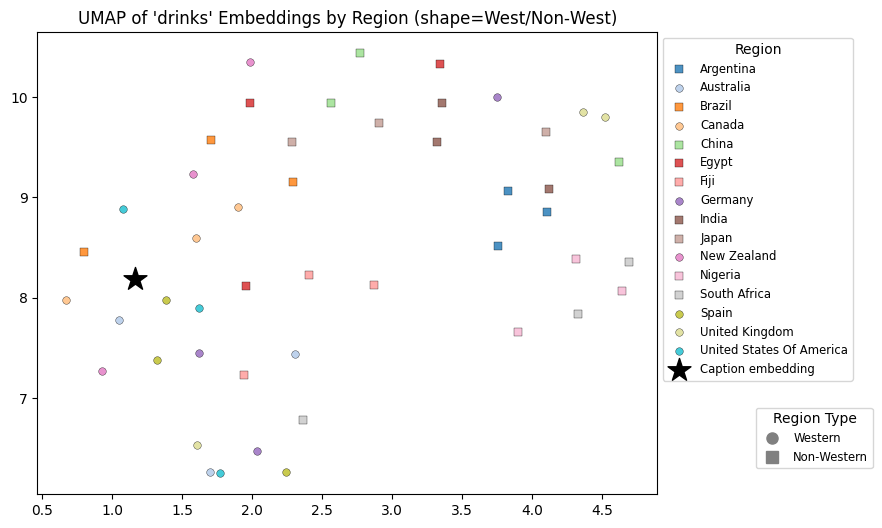

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import hdbscan
from umap.umap_ import UMAP
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# ---- CONFIG ----
CONCEPT   = "drinks"  
FIGSIZE   = (8, 6)
UMAP_ARGS = dict(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)

# ---- 1. Prepare data ----
sub = df[df["universal"] == CONCEPT]

# Stack image embeddings and get regions
img_embs = np.stack(sub["image_embedding"].values)      
regions  = sub["region"].str.title().values            

# Text prototype embedding
cap_emb  = sub["universal_caption_embedding"].iloc[0]  

# Build combined array
X = np.vstack([img_embs, cap_emb[np.newaxis, :]])      

# Build meta‐labels
meta = pd.DataFrame({
    "region": np.concatenate([regions, ["__CAPTION__"]]),
    "modality": np.concatenate([["image"]*len(img_embs), ["text"]])
})

# ---- 2. UMAP projection ----
proj = UMAP(**UMAP_ARGS).fit_transform(X)

# ---- 3. Generate distinct colors for each region ----
unique_regions = np.unique(regions)
cmap = plt.get_cmap("tab20")  # qualitative colormap with up to 20 distinct colors
region_to_color = {
    reg: cmap(i / len(unique_regions)) 
    for i, reg in enumerate(unique_regions)
}

# ---- define your Western set ----
WESTERN = set(western_regions)

# ---- 4. Plot joint 2D scatter with dynamic colors + shapes ----
plt.figure(figsize=FIGSIZE)

for reg in unique_regions:
    mask = (meta["region"] == reg) & (meta["modality"] == "image")
    # pick shape by region type
    if reg.lower() in WESTERN:
        marker = 'o'
    else:
        marker = 's'

    plt.scatter(
        proj[mask, 0],
        proj[mask, 1],
        color=region_to_color[reg],
        marker=marker,
        label=reg,
        s=30,
        alpha=0.8,
        edgecolor='k',       # a thin black edge helps shapes stand out
        linewidth=0.3
    )

# caption prototype remains a black star
cap_idx = len(img_embs)
plt.scatter(
    proj[cap_idx, 0],
    proj[cap_idx, 1],
    marker="*",
    s=300,
    color="black",
    label="Caption embedding"
)

# first legend: one entry per region (colors)
leg1 = plt.legend(
    bbox_to_anchor=(1,1),
    loc="upper left",
    title="Region",
    fontsize="small"
)
plt.gca().add_artist(leg1)

# second legend: shape = Western vs Non‑Western
west_handle = Line2D(
    [], [], color='gray', marker='o', linestyle='None',
    markersize=8, label='Western'
)
nonwest_handle = Line2D(
    [], [], color='gray', marker='s', linestyle='None',
    markersize=8, label='Non‑Western'
)
plt.legend(
    handles=[west_handle, nonwest_handle],
    bbox_to_anchor=(1.15,0.2),
    loc="upper left",
    title="Region Type",
    fontsize="small"
)

plt.title(f"UMAP of '{CONCEPT}' Embeddings by Region (shape=West/Non‑West)")
plt.show()
plt.savefig(f"{CONCEPT}_umap.png")

In [100]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
from matplotlib.lines import Line2D

def plot_umap_by_universal(
    df: pd.DataFrame,
    concept: str,
    western_regions: set,
    out_dir: str = "Visualizations",
    figsize: tuple = (8, 6),
    umap_args: dict = None
):
    """
    Filters df for df['universal']==concept, projects image + caption embeddings via UMAP,
    then plots colored by region and shaped by Western/non‑Western, saving to disk.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['region','universal','image_embedding','universal_caption_embedding'].
    concept : str
        The universal value to plot.
    western_regions : set of str
        Region names (lower‑cased) considered Western.
    out_dir : str
        Directory where PNGs will be saved.
    figsize : tuple
        Matplotlib figure size.
    umap_args : dict
        Arguments passed to UMAP(), e.g. dict(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42).
    """
    # defaults
    if umap_args is None:
        umap_args = dict(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)

    # prepare output folder
    os.makedirs(out_dir, exist_ok=True)
    
    # filter
    sub = df[df["universal"] == concept]
    if sub.empty:
        print(f"[warn] no rows for concept '{concept}'")
        return
    
    # data matrices
    img_embs = np.stack(sub["image_embedding"].values)
    regions  = sub["region"].str.title().values
    cap_emb  = sub["universal_caption_embedding"].iloc[0]
    X = np.vstack([img_embs, cap_emb[np.newaxis, :]])
    
    # metadata
    meta = pd.DataFrame({
        "region": np.concatenate([regions, ["__CAPTION__"]]),
        "modality": np.concatenate([["image"]*len(img_embs), ["text"]])
    })
    
    # project
    proj = UMAP(**umap_args).fit_transform(X)
    
    # color mapping
    unique_regions = np.unique(regions)
    cmap = plt.get_cmap("tab20")
    region_to_color = {
        reg: cmap(i / len(unique_regions)) 
        for i, reg in enumerate(unique_regions)
    }
    
    # plot
    plt.figure(figsize=figsize)
    for reg in unique_regions:
        mask = (meta["region"] == reg) & (meta["modality"] == "image")
        marker = 'o' if reg.lower() in western_regions else 's'
        plt.scatter(
            proj[mask, 0], proj[mask, 1],
            color=region_to_color[reg],
            marker=marker, s=30, alpha=0.8,
            edgecolor='k', linewidth=0.3,
            label=reg
        )
    # caption point
    plt.scatter(
        proj[len(img_embs), 0], proj[len(img_embs), 1],
        marker="*", s=300, color="black", label="Caption embedding"
    )
    # legends
    leg1 = plt.legend(
        bbox_to_anchor=(1,1), loc="upper left",
        title="Region", fontsize="small"
    )
    plt.gca().add_artist(leg1)
    west_handle = Line2D([], [], color='gray', marker='o', linestyle='None',
                         markersize=8, label='Western')
    nonwest_handle = Line2D([], [], color='gray', marker='s', linestyle='None',
                             markersize=8, label='Non‑Western')
    plt.legend(
        handles=[west_handle, nonwest_handle],
        bbox_to_anchor=(1.2,0.2), loc="upper left",
        title="Region Type", fontsize="small"
    )
    plt.title(f"UMAP of '{concept}' Embeddings by Region\n(shape=West/Non‑West)")
    plt.tight_layout()
    
    # save & close
    out_path = os.path.join(out_dir, f"umap_{concept.replace(' ', '_')}.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Saved: {out_path}")


for concept in df["universal"].unique():
    plot_umap_by_universal(df, concept, western_regions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_drinks.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_music.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_eating_habits.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_transport.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_greeting.png
Saved: Visualizations/umap_instrument.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_dessert.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_marriage.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_clothing.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_lunch.png
Saved: Visualizations/umap_dinner.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_sports.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_headcoverings.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_religion.png
Saved: Visualizations/umap_dance.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_funeral.png
Saved: Visualizations/umap_ritual.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved: Visualizations/umap_festival.png
Saved: Visualizations/umap_breakfast.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



    min_cluster_size  n_clusters  noise_fraction  silhouette_score
0                  2           2             0.5          0.144205
1                  3           0             1.0               NaN
2                  4           0             1.0               NaN
3                  5           0             1.0               NaN
4                  6           0             1.0               NaN
5                  7           0             1.0               NaN
6                  8           0             1.0               NaN
7                  9           0             1.0               NaN
8                 10           0             1.0               NaN
9                 11           0             1.0               NaN
10                12           0             1.0               NaN
11                13           0             1.0               NaN
12                14           0             1.0               NaN
13                15           0             1.0              

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

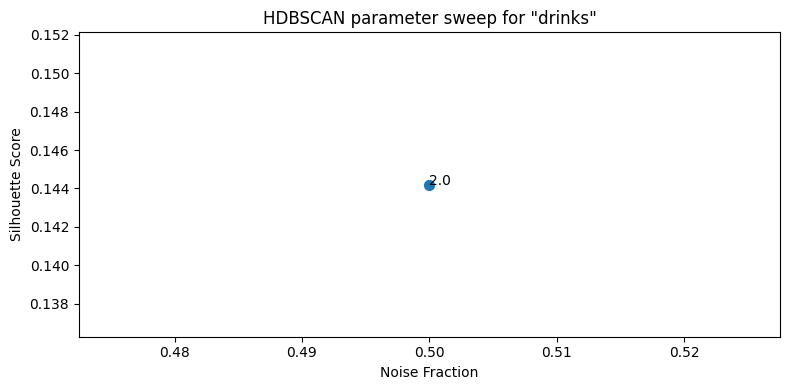

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Make sure df is already defined:
# df should have columns ['region','universal','image_embedding']

CONCEPT = "drinks"
sub = df[df["universal"] == CONCEPT]
X = np.stack(sub["image_embedding"].values)

# Try HDBSCAN if installed, otherwise fall back to DBSCAN
try:
    import hdbscan
    clustering_algo = "HDBSCAN"
except ImportError:
    from sklearn.cluster import DBSCAN
    clustering_algo = "DBSCAN"

results = []

if clustering_algo == "HDBSCAN":
    # Sweep over min_cluster_size
    for mcs in range(2, min(len(X), 16) + 1):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, metric="euclidean")
        labels = clusterer.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = (labels == -1).mean()
        sil = (silhouette_score(X[labels != -1], labels[labels != -1])
               if n_clusters > 1 else np.nan)
        results.append({
            'min_cluster_size': mcs,
            'n_clusters': n_clusters,
            'noise_fraction': noise_frac,
            'silhouette_score': sil
        })

else:
    # Sweep over eps and min_samples for DBSCAN
    eps_vals = np.linspace(0.1, 1.0, 10)
    ms_vals  = [2, 3, 5, 8]
    for eps in eps_vals:
        for ms in ms_vals:
            clusterer = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
            labels = clusterer.fit_predict(X)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_frac = (labels == -1).mean()
            sil = (silhouette_score(X[labels != -1], labels[labels != -1])
                   if n_clusters > 1 else np.nan)
            results.append({
                'eps': round(eps,2),
                'min_samples': ms,
                'n_clusters': n_clusters,
                'noise_fraction': noise_frac,
                'silhouette_score': sil
            })

# Collect and display
res_df = pd.DataFrame(results)
print(res_df)

# Plot noise_fraction vs silhouette_score to spot the Pareto‐optimal region
plt.figure(figsize=(8,4))
plt.scatter(res_df['noise_fraction'], res_df['silhouette_score'], s=50)
for idx, row in res_df.iterrows():
    # label each point by its primary parameter
    label = row.get('min_cluster_size', row.get('eps'))
    plt.annotate(label, (row['noise_fraction'], row['silhouette_score']))
plt.xlabel('Noise Fraction')
plt.ylabel('Silhouette Score')
plt.title(f'{clustering_algo} parameter sweep for "{CONCEPT}"')
plt.tight_layout()
plt.show()

Adjusted Rand Index (UMAP+DBSCAN vs West/Non‑West): 0.081

Cluster composition by region type:
 region_type  Non‑Western  Western
cluster                          
-1                    21       11
 0                     1        4
 1                     1        5
 2                     4        1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



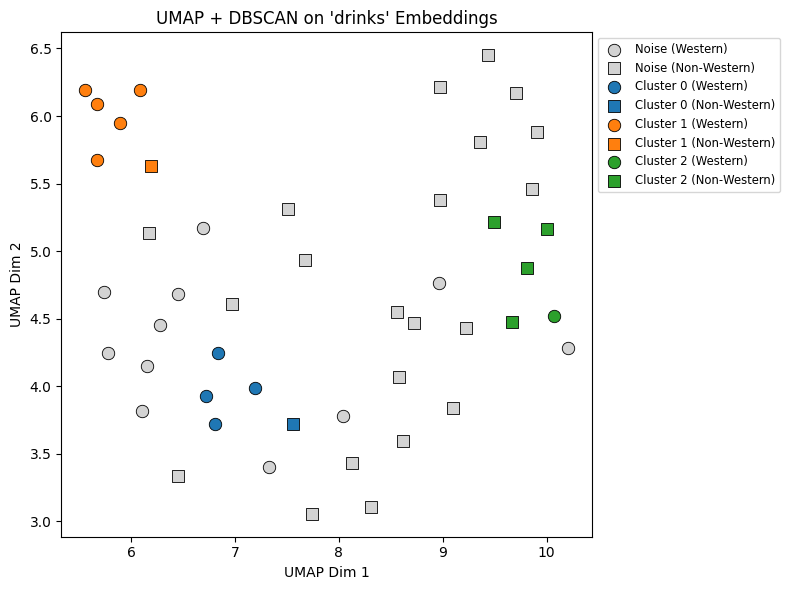

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

# 1) Choose projection method
try:
    from umap import UMAP
    reducer = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    proj_name = "UMAP"
except ImportError:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, metric="cosine", random_state=42)
    proj_name = "t-SNE"

# 2) Config
CONCEPT = "drinks"                      # change to any universal
DBSCAN_PARAMS = {'eps': 0.5, 'min_samples': 5}
WESTERN = western_regions

# 3) Extract the image embeddings and metadata
sub = df[df["universal"] == CONCEPT].reset_index(drop=True)
X = np.stack(sub["image_embedding"].values)    # (N,512)
regions = sub["region"].str.title().values     # e.g. ["Canada", "India", ...]
region_type = np.array([
    "Western" if r.lower() in WESTERN else "Non‑Western"
    for r in sub["region"]
])

# 4) Project into 2D
proj2d = reducer.fit_transform(X)               # (N,2)

# 5) DBSCAN clustering on the 2D points
db = DBSCAN(eps=DBSCAN_PARAMS['eps'],
            min_samples=DBSCAN_PARAMS['min_samples'],
            metric="euclidean")
labels = db.fit_predict(proj2d)                 # -1 = noise

# 6) Evaluate cluster vs region—compute ARI
y_true = LabelEncoder().fit_transform(region_type)
ari = adjusted_rand_score(y_true, labels)
print(f"Adjusted Rand Index ({proj_name}+DBSCAN vs West/Non‑West): {ari:.3f}")

# 7) Show cluster composition
import pandas as pd
comp = pd.DataFrame({
    "cluster": labels,
    "region_type": region_type
}).groupby(["cluster","region_type"]).size().unstack(fill_value=0)
print("\nCluster composition by region type:\n", comp)

# 8) Plot
FIGSIZE = (8,6)
markers = {"Western": "o", "Non‑Western": "s"}
palette = plt.get_cmap("tab10")

plt.figure(figsize=FIGSIZE)
for cl in np.unique(labels):
    color = "lightgrey" if cl == -1 else palette(cl % 10)
    for rt in ["Western","Non‑Western"]:
        mask = (labels == cl) & (region_type == rt)
        if not mask.any(): continue
        plt.scatter(
            proj2d[mask,0], proj2d[mask,1],
            marker=markers[rt], c=[color],
            edgecolor="k", linewidth=0.6,
            s=80,
            label=f"{'Noise' if cl==-1 else 'Cluster '+str(cl)} ({rt})"
        )

plt.title(f"{proj_name} + DBSCAN on '{CONCEPT}' Embeddings")
plt.xlabel(f"{proj_name} Dim 1")
plt.ylabel(f"{proj_name} Dim 2")
plt.legend(bbox_to_anchor=(1,1), fontsize="small")
plt.tight_layout()
plt.show()

K‑Means (k=2) best accuracy vs West/Non‑West = 0.750
Adjusted Rand Index = 0.234


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



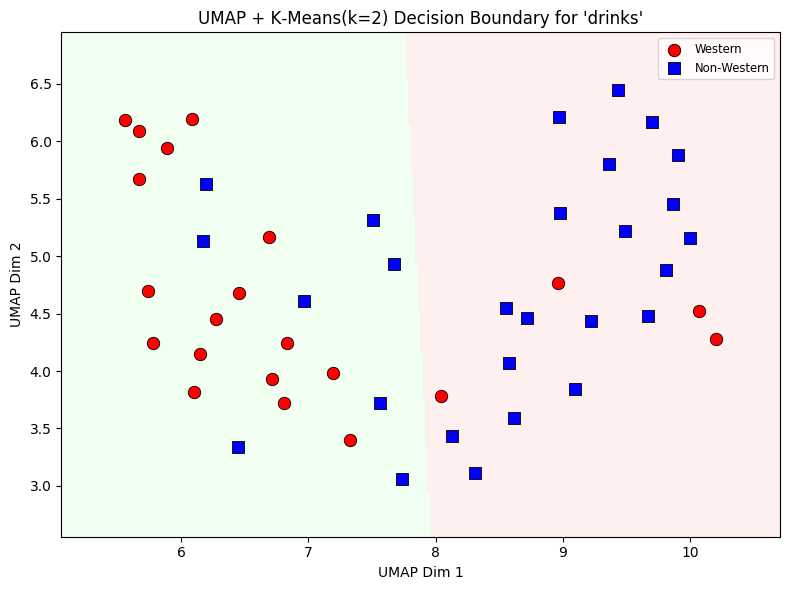

In [29]:
# 5) K‑Means clustering on the 2D projection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score

# 1) Choose projection method
try:
    from umap import UMAP
    reducer = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    proj_name = "UMAP"
except ImportError:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, metric="cosine", random_state=42)
    proj_name = "t-SNE"

# 2) Config
CONCEPT = "drinks"                      # change to any universal
DBSCAN_PARAMS = {'eps': 0.5, 'min_samples': 5}
WESTERN = western_regions

# 3) Extract the image embeddings and metadata
sub = df[df["universal"] == CONCEPT].reset_index(drop=True)
X = np.stack(sub["image_embedding"].values)    # (N,512)
regions = sub["region"].str.title().values     # e.g. ["Canada", "India", ...]
region_type = np.array([
    "Western" if r.lower() in WESTERN else "Non‑Western"
    for r in sub["region"]
])

# 4) Project into 2D
proj2d = reducer.fit_transform(X)               # (N,2)
kmeans2d = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans2d.fit_predict(proj2d)

# 6) Evaluate against true West/Non‑West labels
y_true = np.array([1 if rt == "Western" else 0 for rt in region_type])
acc1 = accuracy_score(y_true, cluster_labels)
acc2 = accuracy_score(y_true, 1 - cluster_labels)
best_acc = max(acc1, acc2)
ari = adjusted_rand_score(y_true, cluster_labels)
print(f"K‑Means (k=2) best accuracy vs West/Non‑West = {best_acc:.3f}")
print(f"Adjusted Rand Index = {ari:.3f}")

# 7) Build a meshgrid for the decision boundary
x_min, x_max = proj2d[:,0].min() - 0.5, proj2d[:,0].max() + 0.5
y_min, y_max = proj2d[:,1].min() - 0.5, proj2d[:,1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
Z = kmeans2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# 8) Plot background + all points
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

# Shade the two cluster regions
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5],
             colors=['#FFDADA', '#DAFFDA'], alpha=0.4)

# Overlay every point, marker by region_type
for rt, marker, color in [('Western','o','red'), ('Non‑Western','s','blue')]:
    mask = region_type == rt
    plt.scatter(
        proj2d[mask,0], proj2d[mask,1],
        marker=marker, c=color, edgecolor='k',
        linewidth=0.6, s=80, label=rt
    )

plt.title(f"{proj_name} + K‑Means(k=2) Decision Boundary for '{CONCEPT}'")
plt.xlabel(f"{proj_name} Dim 1")
plt.ylabel(f"{proj_name} Dim 2")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.manifold import TSNE
# import numpy as np

# # Assuming `embeddings` is a NumPy array of shape (N_images, 512)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# embeddings_2d = tsne.fit_transform(embeddings)  # shape: (N_images, 2)
# print(embeddings_2d[:5])  # print first 5 transformed coordinates

<!-- After reducing to 2D, we can create a scatter plot to visualize the embedding space. We’ll color each point by its region to see if images from the same region cluster together:

Using seaborn makes it easy to add a legend and colors for each region category. In the above plot code, each point represents an image in the dataset projected into 2D, and points are colored by the region. This visualization helps reveal any natural clustering by cultural region. For instance, if images from Western countries cluster separately from images from Asian or African countries, it would be visible here. (Note: For clarity, consider plotting a subset of points if the dataset is large, or adjust perplexity for t-SNE as needed.) -->

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Prepare list of region labels corresponding to the embeddings
# region_labels = [item['region'] for item in ds[:len(embeddings)]] 

# plt.figure(figsize=(8,6))
# sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], 
#                 hue=region_labels, palette="bright", alpha=0.7)
# plt.title("t-SNE of CLIP Image Embeddings (colored by region)")
# plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

<!-- 4. Clustering Embeddings and Evaluating with Silhouette Score

Next, we perform k-means clustering on the image embeddings to see how they group in an unsupervised manner. We can choose a number of clusters k (for example, equal to the number of distinct regions, or an arbitrary value like 5 or 10) and fit KMeans. After clustering, we evaluate the cluster quality using the silhouette score. The silhouette score (range -1 to 1) measures how similar an object is to its own cluster compared to other clusters – higher values indicate well-separated, cohesive clusters (https://medium.com/data-scientists-diary/pytorch-for-unsupervised-clustering-a-practical-guide-38387a3d3bd1#:~:text=from%20sklearn). -->
